In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import datetime

from matplotlib.ticker import FuncFormatter
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from os import path
from matplotlib import ticker

%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 

# Data reading and processing

In [2]:
interval_stat = 1000

def prep (x):
    x['interval'] = np.ceil(x['epsiode']/interval_stat)
    x_rewards = x.groupby(['interval'], as_index=False).agg({'rewards':np.mean, 
                                                             'States_visted_ratio':np.mean, 
                                                             'duration':np.mean, 
                                                             'FM_done':np.sum})
                                                             #'sparsity':np.mean})
    x_conv = x[x['timesteps']==20].groupby(['interval'], as_index=False).agg({'timesteps':np.size})
    x_stat = pd.merge(x_rewards, x_conv, on='interval', how='left')
    x_stat = x_stat.fillna(0)
    x_stat['sum_timesteps'] = x_stat['timesteps'].cumsum()
    x_stat['sum_runtime'] = x_stat['duration'].cumsum()
    x_stat['sum_fm'] = x_stat['FM_done'].cumsum()
    return x_stat 

In [3]:
rangelist = range(0,51)

### Approximation threshold =0.01
FM_threshold=0.01  

df_e_stat = pd.DataFrame()
df_e_fm_stat = pd.DataFrame()
df_b_stat = pd.DataFrame()
df_b_fm_stat = pd.DataFrame()

for i in rangelist:
    file_e = str(FM_threshold)+'/recording_100000_egreedy_FMFalse_Freq'+str(FM_threshold)+'_seed'+str(i)+'.csv'
    file_e_fm = str(FM_threshold)+'/recording_100000_egreedy_FMTrue_Freq'+str(FM_threshold)+'_seed'+str(i)+'.csv'
    file_b = str(FM_threshold)+'/recording_100000_boltzmann_FMFalse_Freq'+str(FM_threshold)+'_seed'+str(i)+'.csv'
    file_b_fm = str(FM_threshold)+'/recording_100000_boltzmann_FMTrue_Freq'+str(FM_threshold)+'_seed'+str(i)+'.csv'
    file_e_once = str(FM_threshold)+'/recording_once_100000_egreedy_FMTrue_Freq'+str(FM_threshold)+'_seed'+str(i)+'.csv'
    file_b_once = str(FM_threshold)+'/recording_once_100000_boltzmann_FMTrue_Freq'+str(FM_threshold)+'_seed'+str(i)+'.csv'
    
    df_e = pd.read_csv(file_e)
    df_e_fm = pd.read_csv(file_e_fm)
    df_b = pd.read_csv(file_b)
    df_b_fm = pd.read_csv(file_b_fm)
    df_e_once = pd.read_csv(file_e_once)
    df_b_once = pd.read_csv(file_b_once)
    
    df_e = prep(df_e)
    df_e_fm =prep(df_e_fm)
    df_b = prep(df_b)
    df_b_fm = prep(df_b_fm)
    df_e_once = prep(df_e_once)
    df_b_once = prep(df_b_once)    

    if i==0:
        df_e_stat = df_e
        df_e_fm_stat = df_e_fm
        df_b_stat = df_b
        df_b_fm_stat = df_b_fm
        df_e_once_stat = df_e_once
        df_b_once_stat = df_b_once
        
    df_e_stat = df_e_stat.append(df_e)
    df_e_fm_stat = df_e_fm_stat.append(df_e_fm)
    df_b_stat = df_b_stat.append(df_b)
    df_b_fm_stat = df_b_fm_stat.append(df_b_fm)
    df_e_once_stat = df_e_once_stat.append(df_e_once)
    df_b_once_stat = df_b_once_stat.append(df_b_once)
    
y1 = df_b_stat.groupby(['interval'], as_index=False)['timesteps'].mean()
y1err = df_b_stat.groupby(['interval'], as_index=False)['timesteps'].std()
yb = y1['timesteps'];
yberr = y1err['timesteps']
y2 = df_b_fm_stat.groupby(['interval'], as_index=False)['timesteps'].mean()
y2err = df_b_fm_stat.groupby(['interval'], as_index=False)['timesteps'].std()
ybfm = y2['timesteps'];
ybfmerr = y2err['timesteps']
y3 = df_b_once_stat.groupby(['interval'], as_index=False)['timesteps'].mean()
y3err = df_b_once_stat.groupby(['interval'], as_index=False)['timesteps'].std()
ybfm_once = y3['timesteps'];
ybfmerr_once = y3err['timesteps']

y1 = df_e_stat.groupby(['interval'], as_index=False)['timesteps'].mean()
y1err = df_e_stat.groupby(['interval'], as_index=False)['timesteps'].std()
ye = y1['timesteps'];
yeerr = y1err['timesteps']
y2 = df_e_fm_stat.groupby(['interval'], as_index=False)['timesteps'].mean()
y2err = df_e_fm_stat.groupby(['interval'], as_index=False)['timesteps'].std()
yefm = y2['timesteps'];
yefmerr = y2err['timesteps']
y3 = df_e_once_stat.groupby(['interval'], as_index=False)['timesteps'].mean()
y3err = df_e_once_stat.groupby(['interval'], as_index=False)['timesteps'].std()
yefm_once = y3['timesteps'];
yefmerr_once = y3err['timesteps']

df_b_stat_gb = df_b_stat.groupby(['interval'], as_index=False).mean()
df_b_fm_stat_gb = df_b_fm_stat.groupby(['interval'], as_index=False).mean()
df_b_once_stat_gb = df_b_once_stat.groupby(['interval'], as_index=False).mean()
df_e_stat_gb = df_e_stat.groupby(['interval'], as_index=False).mean()
df_e_fm_stat_gb = df_e_fm_stat.groupby(['interval'], as_index=False).mean()
df_e_once_stat_gb = df_e_once_stat.groupby(['interval'], as_index=False).mean()


df_b_stat_gb.columns=['b_interval', 'b_runtime', 'b_rewards', 'b_FM', 'b_SVR', 'b_converge', 'b_cumsum_converge', 'b_cumsum_runtime','b_cumsum_FM']
df_b_fm_stat_gb.columns=['b_interval_fm', 'b_runtime_fm', 'b_rewards_fm', 'b_FM_fm', 'b_SVR_fm', 'b_converge_fm', 'b_cumsum_converge_fm','b_cumsum_runtime_fm', 'b_cumsum_FM_fm']
df_b_once_stat_gb.columns=['b_interval_once', 'b_runtime_once', 'b_rewards_once', 'b_FM_once', 'b_SVR_once', 'b_converge_once', 'b_cumsum_converge_once','b_cumsum_runtime_once', 'b_cumsum_FM_once']
df_e_stat_gb.columns=['e_interval', 'e_runtime', 'e_rewards', 'e_FM', 'e_SVR', 'e_converge', 'e_cumsum_converge', 'e_cumsum_runtime','e_cumsum_FM']
df_e_fm_stat_gb.columns=['e_interval_fm', 'e_runtime_fm', 'e_rewards_fm', 'e_FM_fm', 'e_SVR_fm', 'e_converge_fm', 'e_cumsum_converge_fm', 'e_cumsum_runtime_fm','e_cumsum_FM_fm']
df_e_once_stat_gb.columns=['e_interval_once', 'e_runtime_once', 'e_rewards_once', 'e_FM_once', 'e_SVR_once', 'e_converge_once', 'e_cumsum_converge_once', 'e_cumsum_runtime_once','e_cumsum_FM_once']

df_b_total_01 = pd.concat([df_b_stat_gb,df_b_fm_stat_gb,df_b_once_stat_gb], axis = 1)
df_e_total_01 = pd.concat([df_e_stat_gb,df_e_fm_stat_gb,df_e_once_stat_gb], axis = 1)

# Figure 6 (b)

C:\Users\BoM\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook.py:2224: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\BoM\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\BoM\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_base.py:252: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


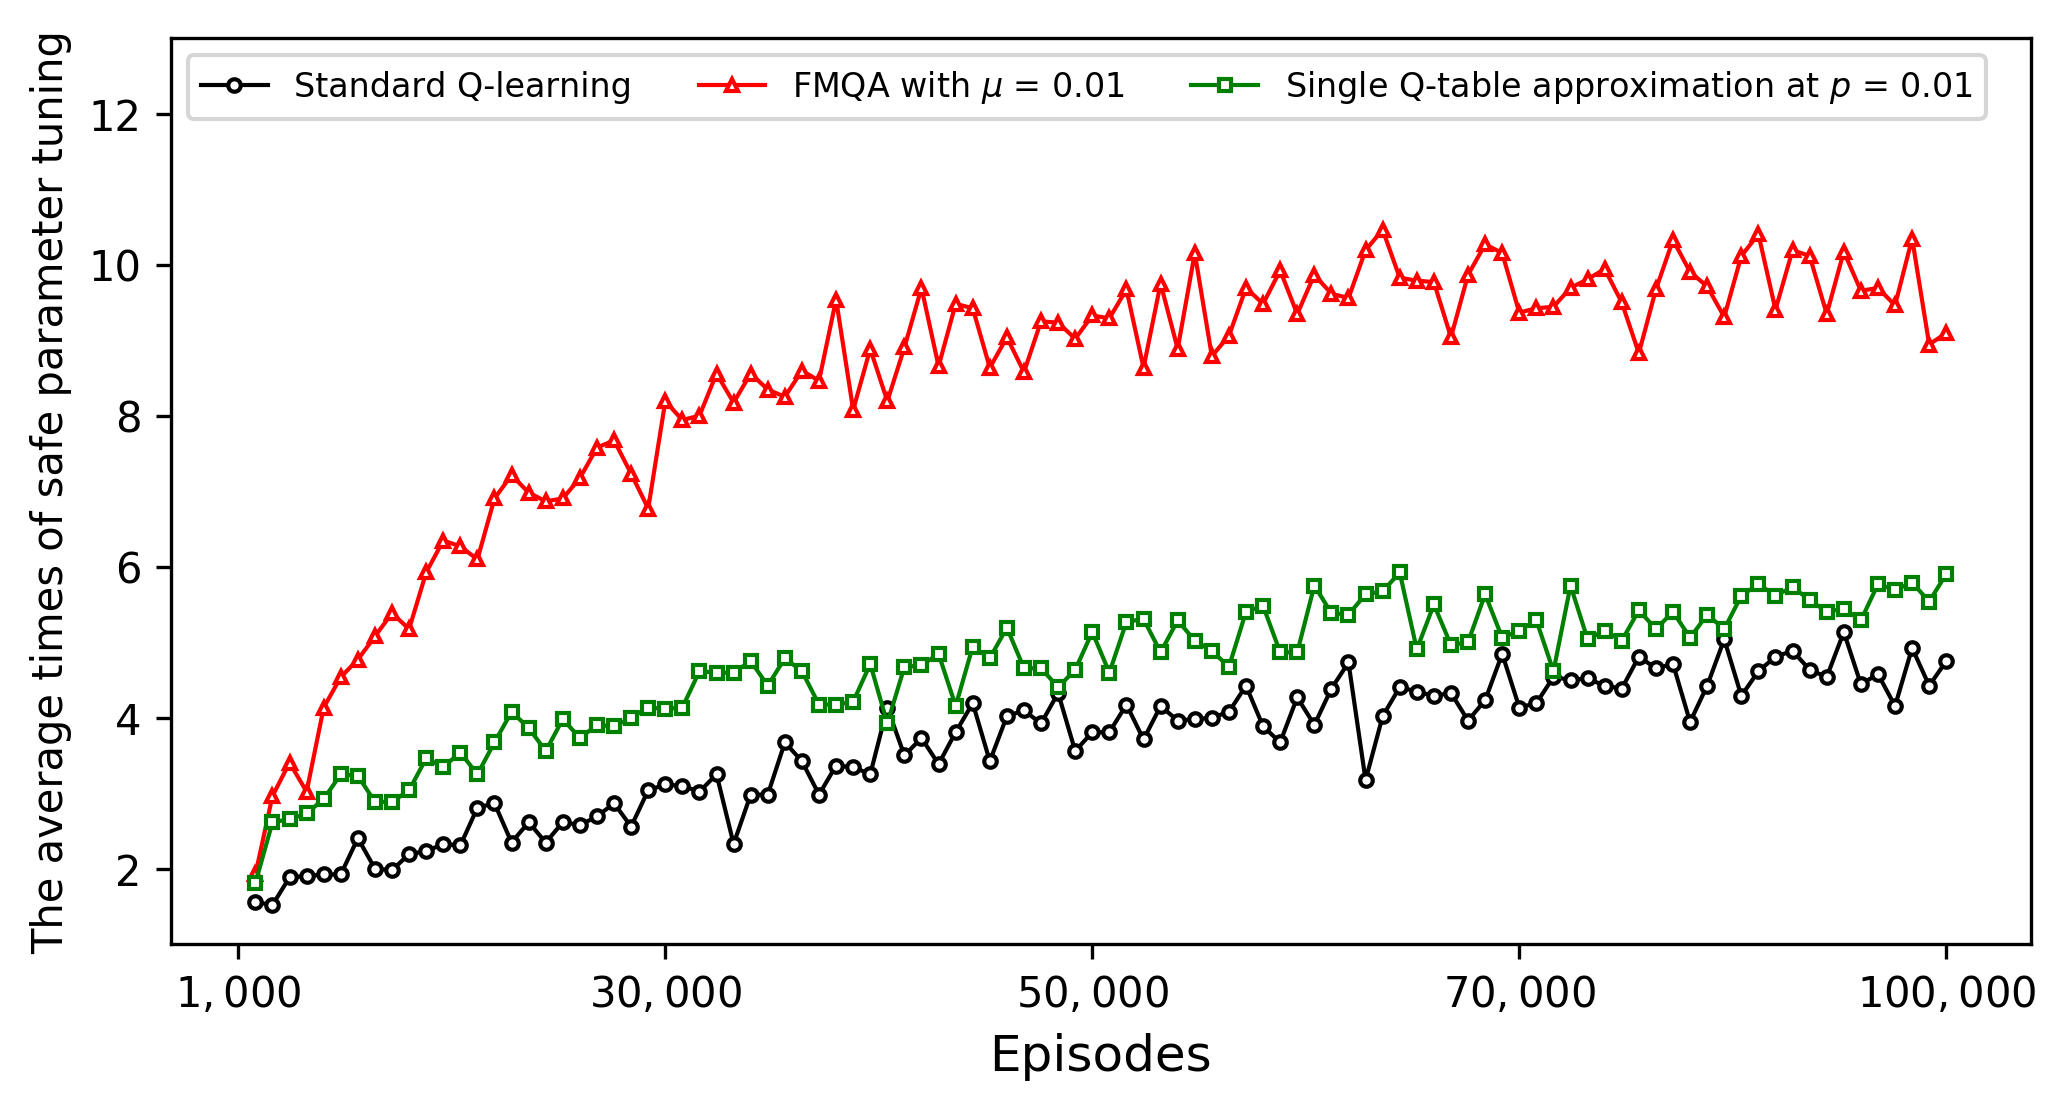

In [4]:
fig, ax1 = plt.subplots()

ax1.plot(df_b_stat_gb['b_interval'], df_b_stat_gb['b_converge'],linewidth=1, color='k', marker='o',markeredgecolor='k',markerfacecolor='white',markersize=3, label='Standard Q-learning')
ax1.plot(df_b_fm_stat_gb['b_interval_fm'], df_b_fm_stat_gb['b_converge_fm'],linewidth=1, color='r', marker='^',markeredgecolor='r', markerfacecolor='white',markersize=3, label='FMQA with '+r'$\mu$'+' = 0.01')
ax1.plot(df_b_once_stat_gb['b_interval_once'], df_b_once_stat_gb['b_converge_once'],linewidth=1, color='g', marker='s',markeredgecolor='g', markerfacecolor='white',markersize=3, label='Single Q-table approximation at '+ '$p$' +' = 0.01')

ax1.legend(prop={'size': 8},loc=2,ncol=3,numpoints = 1)
ax1.set_xlabel('Episodes', fontsize=12)
#ax1.set_ylabel('Convergence episodes', fontsize=12)
ax1.set_ylabel('The average times of safe parameter tuning', fontsize=10)
plt.xticks([0, 25, 50, 75, 100], [r'$1,000$', r'$30,000$', r'$50,000$', r'$70,000$', r'$100,000$'])
ax1.set_ylim([1,13])
plt.show()

# Figure 6 (a)

C:\Users\BoM\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook.py:2224: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\BoM\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\BoM\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_base.py:252: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


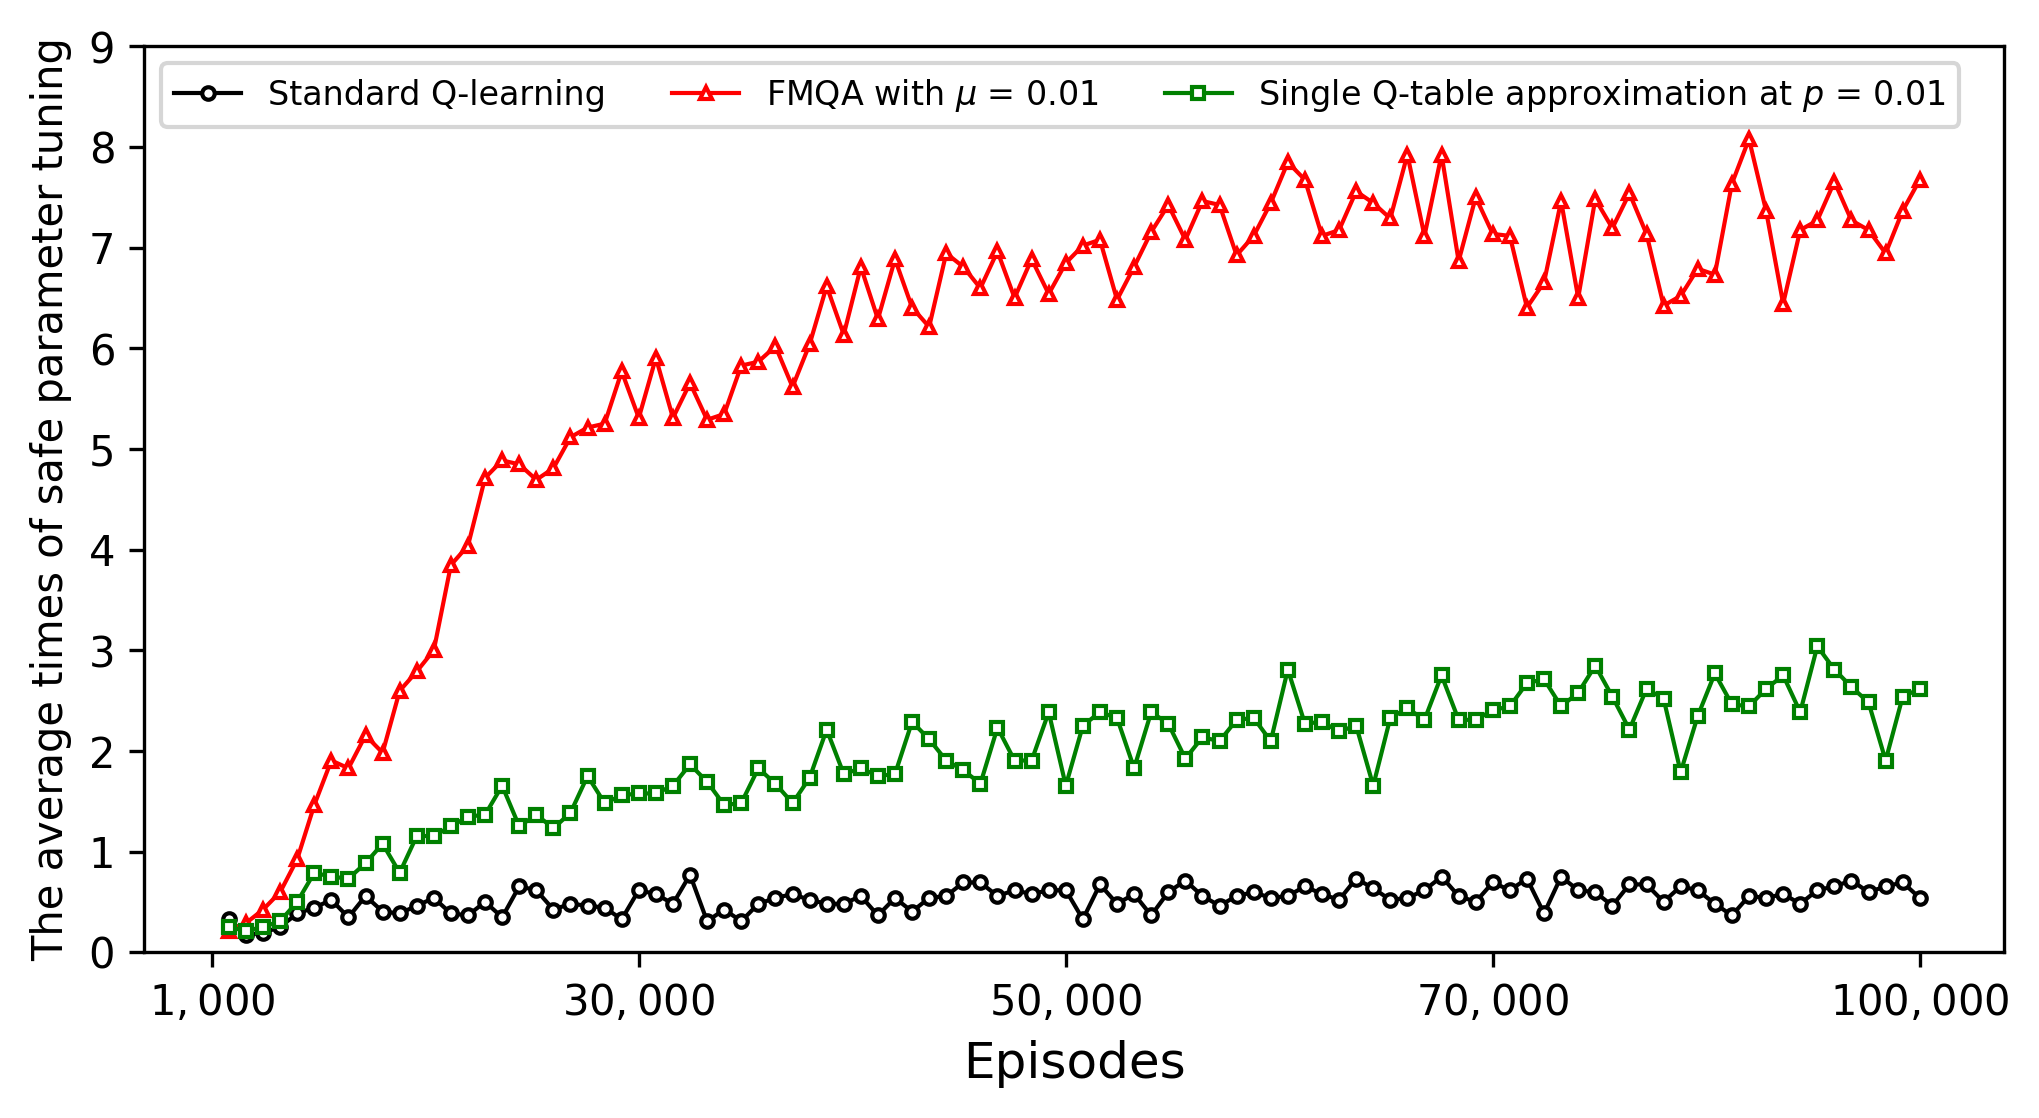

In [5]:
fig, ax1 = plt.subplots()

ax1.plot(df_e_stat_gb['e_interval'], df_e_stat_gb['e_converge'],linewidth=1, color='k', marker='o',markeredgecolor='k',markerfacecolor='white',markersize=3, label='Standard Q-learning')
ax1.plot(df_e_fm_stat_gb['e_interval_fm'], df_e_fm_stat_gb['e_converge_fm'],linewidth=1, color='r', marker='^',markeredgecolor='r', markerfacecolor='white',markersize=3, label='FMQA with '+r'$\mu$'+' = 0.01')
ax1.plot(df_e_once_stat_gb['e_interval_once'], df_e_once_stat_gb['e_converge_once'],linewidth=1, color='g', marker='s',markeredgecolor='g', markerfacecolor='white',markersize=3, label='Single Q-table approximation at '+ '$p$' +' = 0.01')

ax1.legend(prop={'size': 8},loc=2,ncol=3,numpoints = 1)
ax1.set_xlabel('Episodes', fontsize=12)
#ax1.set_ylabel('Convergence episodes', fontsize=12)
ax1.set_ylabel('The average times of safe parameter tuning', fontsize=10)
plt.xticks([0, 25, 50, 75, 100], [r'$1,000$', r'$30,000$', r'$50,000$', r'$70,000$', r'$100,000$'])
ax1.set_ylim([0,9])
plt.show()